License
MIT License

Copyright (c) 2024 kevinetesham4@gwu.edu, ben.eber@gwu.edu, acadiagrenier@gwu.edu, livgao26@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Titanic Kaggle Competition

In [35]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep')

SEED = 42

In [36]:
train = pd.read_csv("/content/titanic_train.csv")
test = pd.read_csv("/content/titanic_test.csv")
combine = pd.concat([train.drop('Survived', axis = 1),test])

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [38]:
print(train.shape)
train.columns

(891, 12)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Deal with NA

In [39]:
train.isnull().any()

,0
PassengerId,False
Survived,False
Pclass,False
Name,False
Sex,False
Age,True
SibSp,False
Parch,False
Ticket,False
Fare,False


In [40]:
nas = train.loc[train.isnull().any(axis=1)]
train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [41]:
nas

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [42]:
train["Age"] = train["Age"].fillna(method = 'pad')

# EDA

In [43]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.00000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.58156,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.55459,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.42000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.00000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.00000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.00000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.00000,8.000000,6.000000,512.329200


## Histograms of data distributions

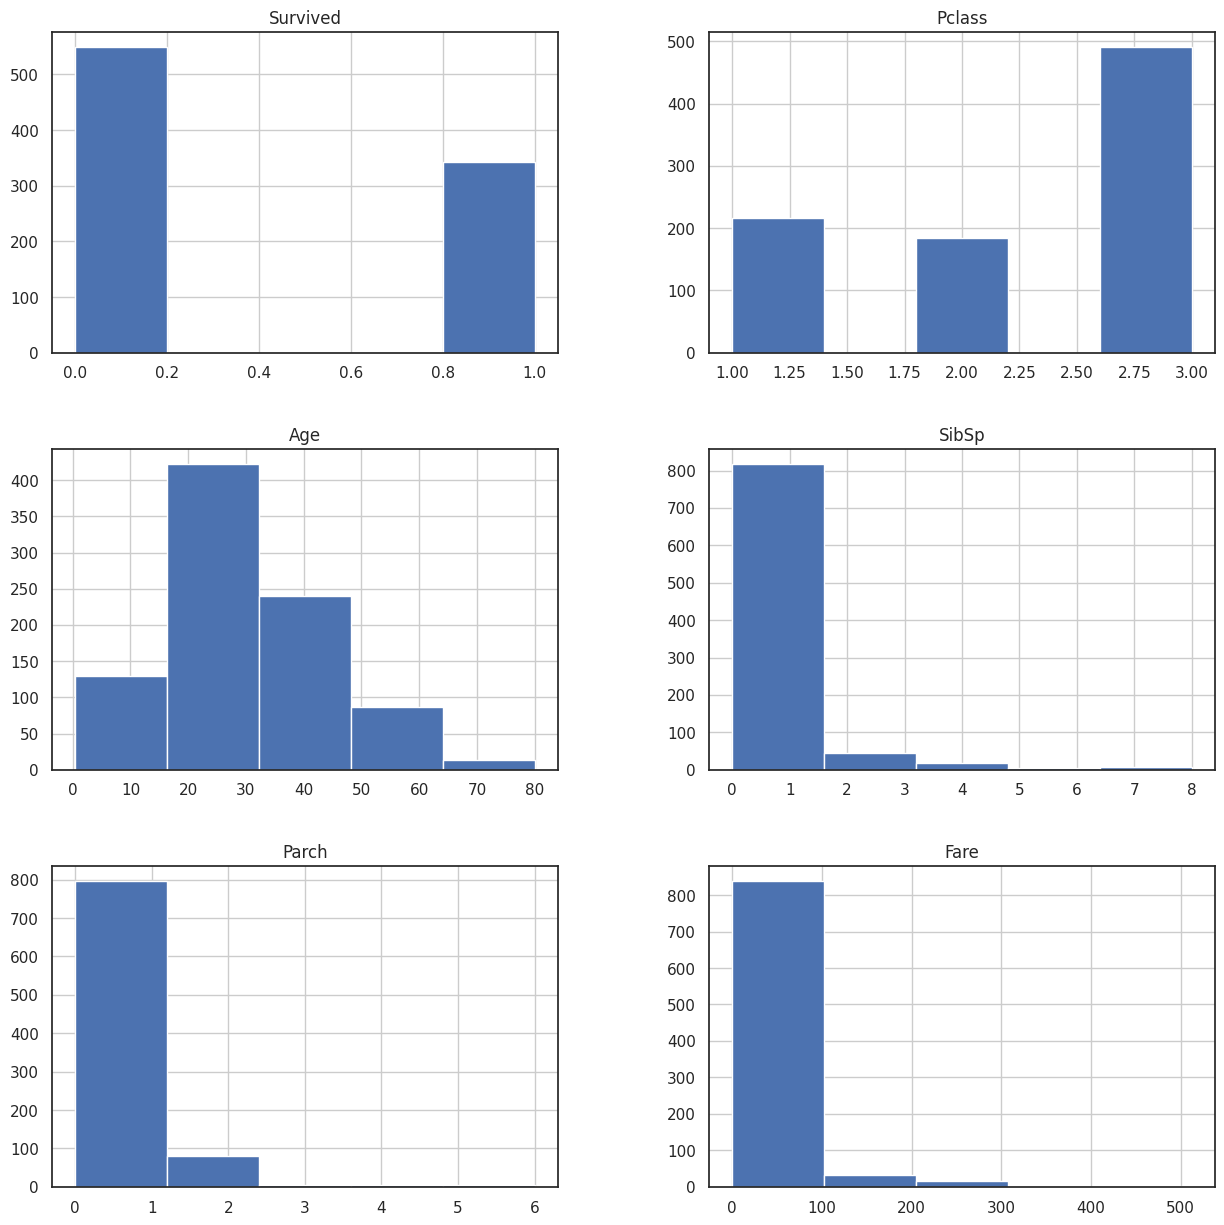

In [44]:
_ = train.drop(columns=["PassengerId"]).hist(bins=5, figsize=(15, 15))

In [45]:
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      %(len(surv), 1.*len(surv)/len(train)*100.0,\
        len(nosurv), 1.*len(nosurv)/len(train)*100.0, len(train)))

Survived: 342 (38.4 percent), Not Survived: 549 (61.6 percent), Total: 891


## Graphs of distributions based on survival status

Median age survivors: 28.0, Median age non-survivers: 28.0


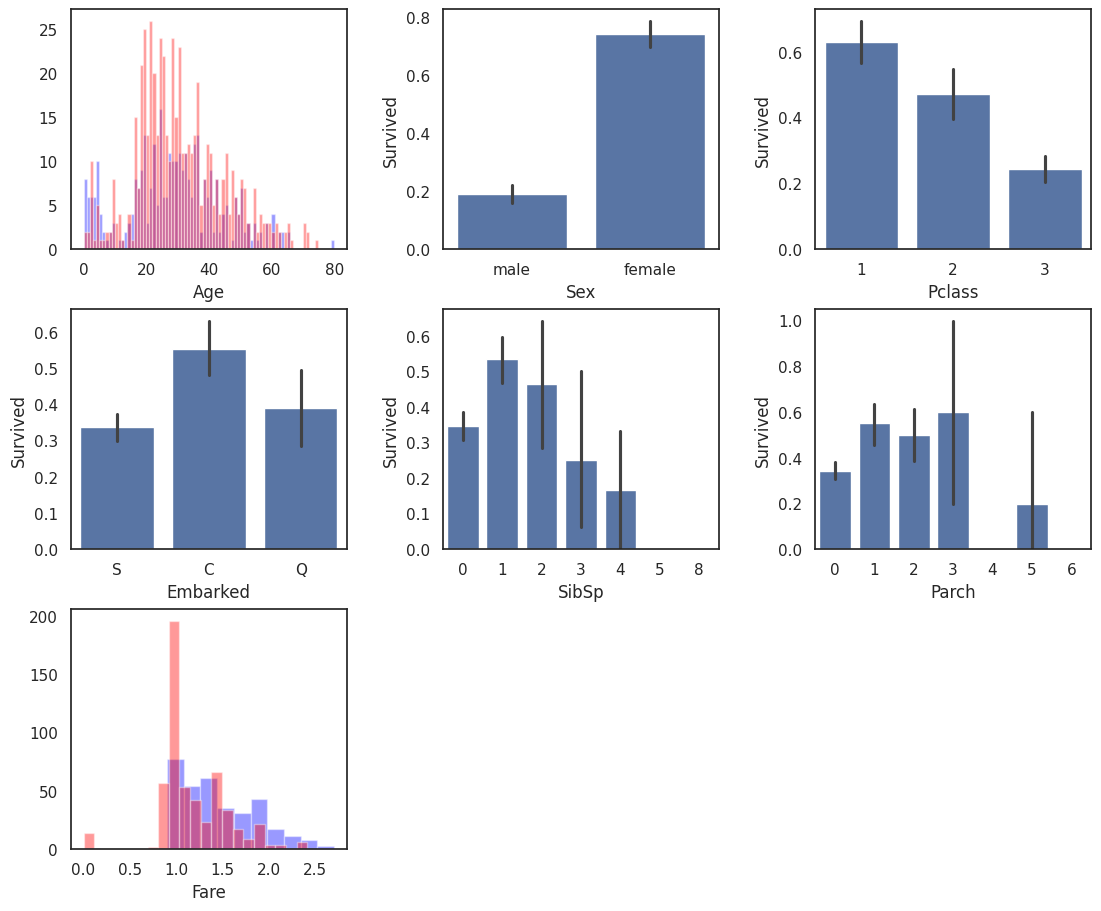

In [46]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Age')
plt.subplot(332)
sns.barplot(x='Sex', y='Survived', data=train)
plt.subplot(333)
sns.barplot(x='Pclass', y='Survived', data=train)
plt.subplot(334)
sns.barplot(x='Embarked', y='Survived', data=train)
plt.subplot(335)
sns.barplot(x='SibSp', y='Survived', data=train)
plt.subplot(336)
sns.barplot(x='Parch', y='Survived', data=train)
plt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

## Pair plots of distributions based on survival status

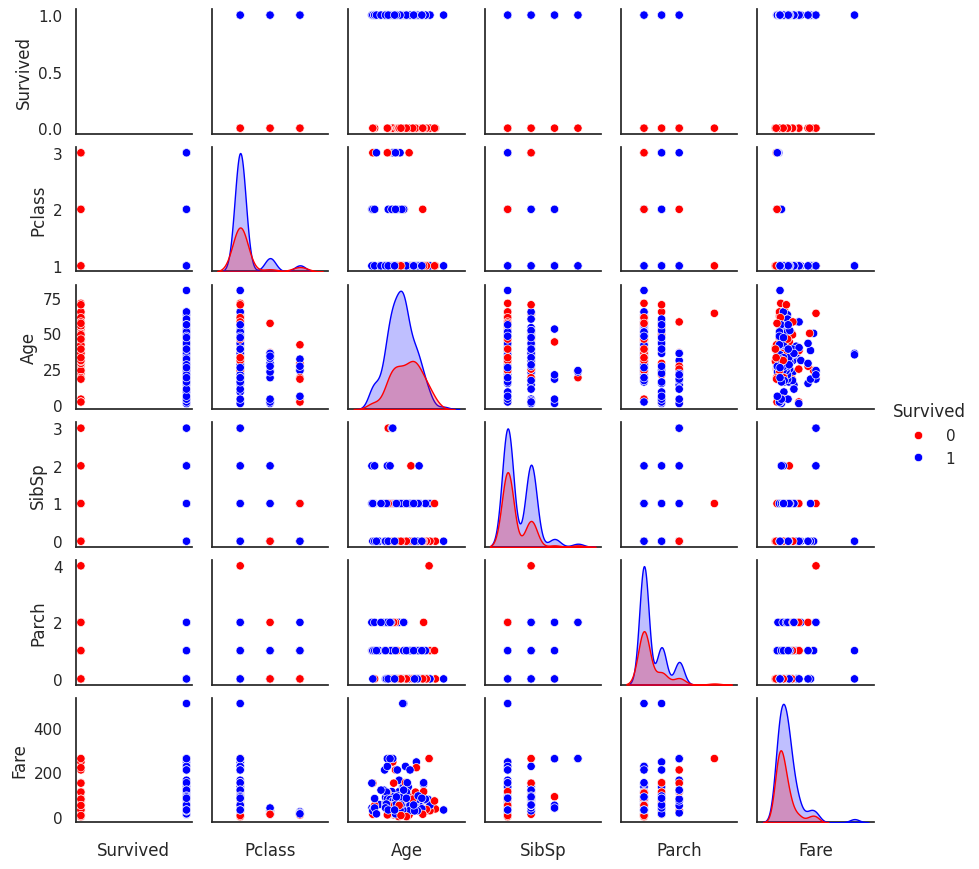

In [47]:
cols = ['Survived','Pclass','Age','SibSp','Parch','Fare']
g = sns.pairplot(data=train.dropna(), vars=cols, size=1.5,
                 hue='Survived', palette=[nosurv_col,surv_col])
g.set(xticklabels=[])

# Correlation visualization

In [48]:
y_name = 'Survived'
X_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [49]:
numerical_features = train.select_dtypes(include=[np.number]).columns
numerical_features = numerical_features.drop('PassengerId', errors='ignore')
numerical_features

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

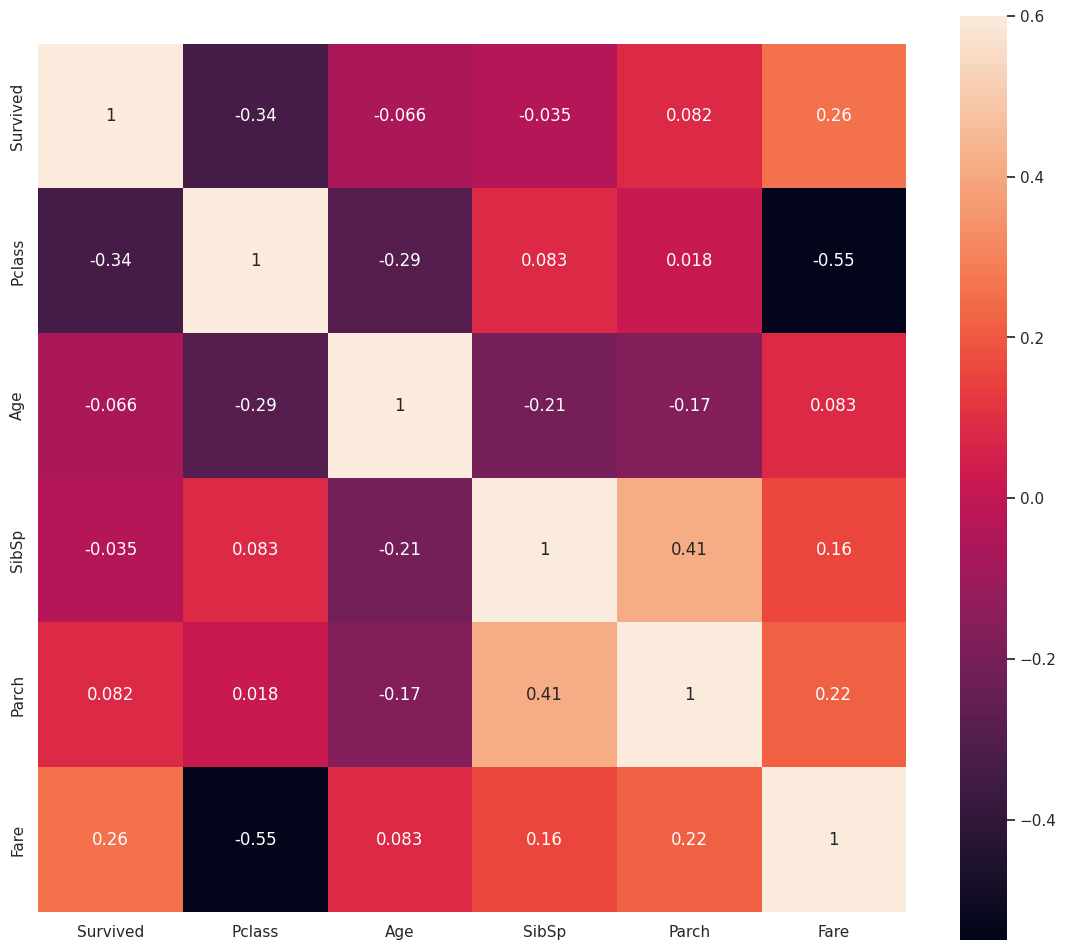

In [50]:
plt.figure(figsize=(14,12))
foocorrmat = train[numerical_features].corr()
foo = sns.heatmap(foocorrmat, vmax=0.6, square=True, annot=True)

# Model

In [51]:
train_X, valid_test_X, train_y, valid_test_y = train_test_split(train[X_names], train[y_name], test_size=0.3, random_state=SEED) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.3, random_state=SEED) # split remainder into validation and test

# summarize
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

# housekeeping
del valid_test_X
del valid_test_y

Training data: 623 rows and 6 columns
Validation data: 187 rows and 6 columns
Testing data: 81 rows and 6 columns


## Run first model

In [52]:
clf_ext = ExtraTreesClassifier(
    max_features=5,
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=8,
    min_samples_split=2,
    random_state=SEED
    )
clf_ext = clf_ext.fit(train_X, train_y)
score_ext = cross_val_score(clf_ext, train_X, train_y, cv=5).mean()
print(score_ext)

0.7046322580645162


## Find best model parameters using validation data

In [53]:
clf_ext = ExtraTreesClassifier(max_features=5,bootstrap=True,oob_score=True)
param_grid = { "criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 3, 5, 7, 10],
              "min_samples_split" : [2, 4, 6, 8, 10, 12],
              "n_estimators": [5, 10, 15, 20, 25, 50, 75, 100],
              "random_state": [SEED]}
gs = GridSearchCV(estimator=clf_ext, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(valid_X, valid_y)
print(gs.best_score_)
print(gs.best_params_)

0.7645502645502645
{'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'random_state': 42}


In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
ns_probs = [0 for _ in range(len(valid_X))]

# predict probabilities
#lr_probs = clf_ext.predict_proba(valid_X)
lr_probs = gs.best_estimator_.predict_proba(valid_X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(valid_y, ns_probs)
ClassScore0 = roc_auc_score(valid_y, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Validation Data: ROC AUC=%.3f' % (ClassScore0))

No Skill: ROC AUC=0.500
Validation Data: ROC AUC=0.885


## Run model on training data with best parameters

In [57]:
clf_ext = ExtraTreesClassifier(
    max_features=5,
    bootstrap=True,
    oob_score=True,
    criterion='entropy',
    min_samples_leaf=3,
    min_samples_split=8,
    n_estimators=100,
    random_state=SEED
    )
clf_ext = clf_ext.fit(train_X, train_y)
score_ext = clf_ext.score(train_X, train_y)
print(score_ext)
print('\nFeature Importance:')
pd.DataFrame(list(zip(train_X.columns, np.transpose(clf_ext.feature_importances_))) \
            ).sort_values(1, ascending=False)

0.7720706260032103

Feature Importance:


,0,1
1,Age,0.288290
4,Fare,0.246599
0,Pclass,0.238478
3,Parch,0.127615
2,SibSp,0.099018


In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
ns_probs = [0 for _ in range(len(train_y))]

# predict probabilities
lr_probs = clf_ext.predict_proba(train_X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(train_y, ns_probs)
ClassScore0 = roc_auc_score(train_y, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Training Data: ROC AUC=%.3f' % (ClassScore0))

No Skill: ROC AUC=0.500
Training Data: ROC AUC=0.862


## Run model on test data and create submission

In [59]:
print("Hyperparameters of model:")
for param, value in clf_ext.get_params().items():
    print(f"{param}: {value}")

Hyperparameters of model:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: None
max_features: 5
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 3
min_samples_split: 8
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: True
random_state: 42
verbose: 0
warm_start: False


In [60]:
clf = clf_ext
df2 = test.loc[:,X_names].fillna(method='pad')
surv_pred = clf.predict(df2)

In [61]:
submit = pd.DataFrame({'PassengerId' : test.loc[:,'PassengerId'],
                       'Survived': surv_pred.T})
submit.to_csv("/content/titanic_train.csv", index=False)
submit.to_csv("fill.csv", index=False)